# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, metrics, layers
from sklearn.model_selection import train_test_split
import random
import numpy as np
import os
import cv2
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from collections import Counter


import tensorflow as tf
from tensorflow.keras import layers, models


#Intialize Random Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
warnings.filterwarnings("ignore")

2025-08-15 18:36:40.130058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755283000.448397      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755283000.529125      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get the Videos

In [2]:
dataset_path = r"/kaggle/input/anti-theft-dataset/Shop DataSet"

In [3]:
non_shop_lifters_path = os.path.join(dataset_path, "non shop lifters")
shop_lifters_path = os.path.join(dataset_path, "shop lifters")

In [4]:
def list_mp4_videos(folder_path):
    """Return a list of all .mp4 video files in a folder."""
    videos = [
        os.path.join(folder_path, file)
        for file in os.listdir(folder_path)
        if file.lower().endswith('.mp4')
    ]

    print(f"\nTotal videos in '{folder_path}': {len(videos)}")
    return videos

# Retrieve video lists from both categories
non_shop_lifters_videos = list_mp4_videos(non_shop_lifters_path)
shop_lifters_videos = list_mp4_videos(shop_lifters_path)


Total videos in '/kaggle/input/anti-theft-dataset/Shop DataSet/non shop lifters': 531

Total videos in '/kaggle/input/anti-theft-dataset/Shop DataSet/shop lifters': 324


In [5]:
def get_video_duration(video_path):
    """Return the duration of a video in seconds, or None if it can't be calculated."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()

    return (total_frames / fps) if fps > 0 else None

def get_lengths(video_list):
    """Return list of durations for valid videos."""
    return [duration for video in video_list
            if (duration := get_video_duration(video)) is not None]

# Calculate lengths
non_shop_lengths = get_lengths(non_shop_lifters_videos)
shop_lengths = get_lengths(shop_lifters_videos)

# Prepare indices for plotting
non_shop_indices = list(range(len(non_shop_lengths)))
shop_indices = list(range(len(non_shop_lengths), len(non_shop_lengths) + len(shop_lengths)))


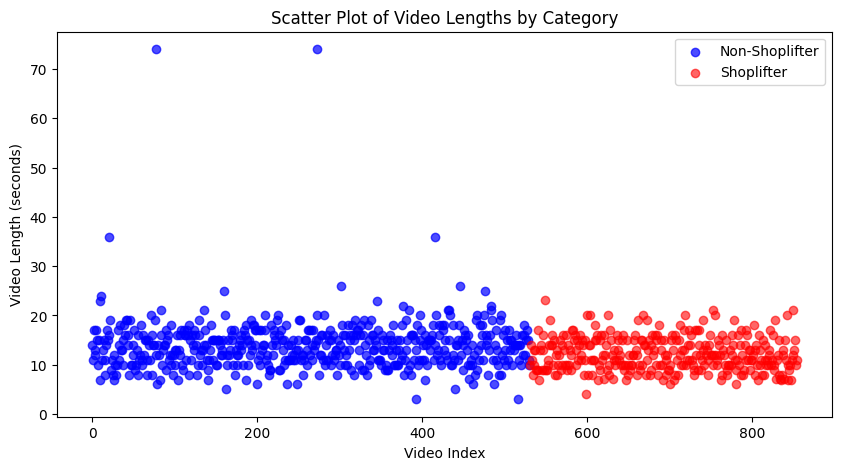

In [6]:
# Plot
plt.figure(figsize=(10, 5))
plt.scatter(non_shop_indices, non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.7)
plt.scatter(shop_indices, shop_lengths, color="red", label="Shoplifter", alpha=0.6)

plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title("Scatter Plot of Video Lengths by Category")
plt.legend()
plt.show()

In [7]:
# Threshold for video length
MAX_VIDEO_LENGTH = 30

def filter_lengths(lengths, max_length):
    """Return lengths that are less than or equal to max_length."""
    return [l for l in lengths if l <= max_length]

# Filter lengths
filtered_non_shop_lengths = filter_lengths(non_shop_lengths, MAX_VIDEO_LENGTH)
filtered_shop_lengths = filter_lengths(shop_lengths, MAX_VIDEO_LENGTH)

# Indices for plotting
filtered_non_shop_indices = range(len(filtered_non_shop_lengths))
filtered_shop_indices = range(len(filtered_non_shop_lengths),
                              len(filtered_non_shop_lengths) + len(filtered_shop_lengths))


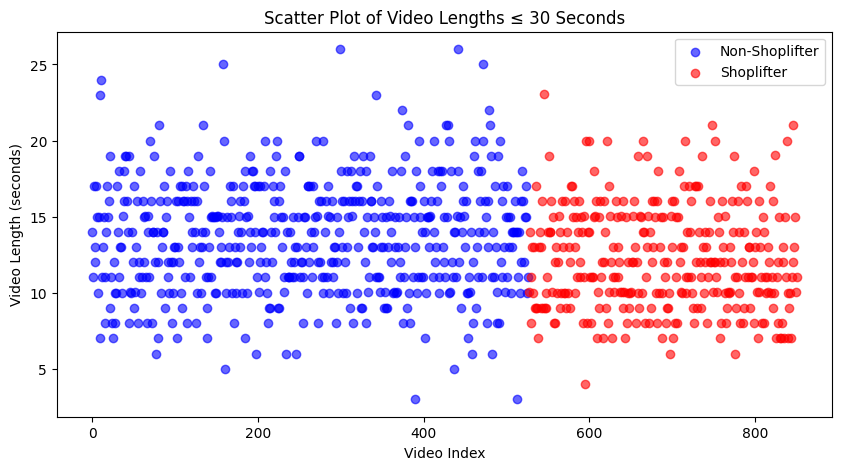

In [8]:

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_non_shop_indices, filtered_non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(filtered_shop_indices, filtered_shop_lengths, color="red", label="Shoplifter", alpha=0.6)

plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title(f"Scatter Plot of Video Lengths ≤ {MAX_VIDEO_LENGTH} Seconds")
plt.legend()
plt.show()


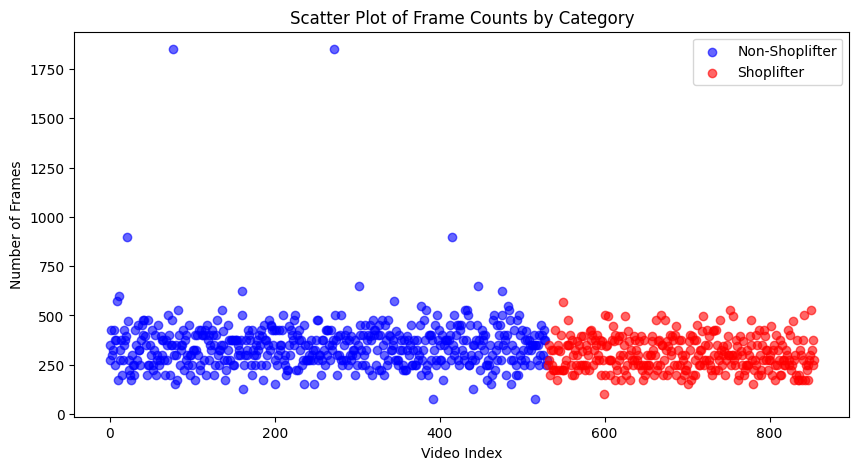

In [9]:
import cv2
import matplotlib.pyplot as plt

def get_video_frame_count(video_path):
    """Return the total number of frames in a video."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames if total_frames > 0 else None

def get_frame_counts(video_list):
    """Return a list of valid frame counts for videos."""
    return [frames for video in video_list
            if (frames := get_video_frame_count(video)) is not None]

# Get frame counts for both categories
non_shop_frames = get_frame_counts(non_shop_lifters_videos)
shop_frames = get_frame_counts(shop_lifters_videos)

# Create indices for plotting
non_shop_indices = range(len(non_shop_frames))
shop_indices = range(len(non_shop_frames), len(non_shop_frames) + len(shop_frames))

# Plot scatter
plt.figure(figsize=(10, 5))
plt.scatter(non_shop_indices, non_shop_frames, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(shop_indices, shop_frames, color="red", label="Shoplifter", alpha=0.6)

plt.xlabel("Video Index")
plt.ylabel("Number of Frames")
plt.title("Scatter Plot of Frame Counts by Category")
plt.legend()
plt.show()


# Preprocessing

In [10]:
import os
from collections import Counter
from sklearn.model_selection import train_test_split

# --- Configuration ---
IMG_SIZE = (128, 128)       # Resize frames
NUM_FRAMES = 16             # Fixed number of frames per video
BATCH_SIZE = 4              # Batch size (adjust for GPU memory)
BUFFER_SIZE = 100           # Shuffle buffer size
CHANNELS = 3                # RGB channels
CATEGORIES = {
    "non shop lifters": 0,  # Label 0
    "shop lifters": 1       # Label 1
}

# --- Helper: List all .mp4 videos in a folder ---
def list_mp4_videos(folder_path):
    """Return full paths to all .mp4 videos in the given folder."""
    return [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(".mp4")
    ]

# --- Collect all videos & labels ---
video_paths, labels = [], []
for category, label in CATEGORIES.items():
    category_path = os.path.join(dataset_path, category)
    videos = list_mp4_videos(category_path)
    video_paths.extend(videos)
    labels.extend([label] * len(videos))

# --- Decide stratification ---
label_counts = Counter(labels)
min_class_count = min(label_counts.values())
stratify_labels = labels if min_class_count >= 2 else None

# --- Train/validation split ---
train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths,
    labels,
    test_size=0.3,
    random_state=SEED,
    stratify=stratify_labels
)

# --- Dataset sizes ---
num_train_samples = len(train_paths)
num_val_samples = len(val_paths)

# --- Steps per epoch ---
steps_per_epoch = max(1, num_train_samples // BATCH_SIZE)
validation_steps = max(1, num_val_samples // BATCH_SIZE)

# --- Optional: Show summary ---
print(f"Training samples: {num_train_samples}, Steps/Epoch: {steps_per_epoch}")
print(f"Validation samples: {num_val_samples}, Validation Steps: {validation_steps}")
print("Label distribution (train):", Counter(train_labels))
print("Label distribution (val):  ", Counter(val_labels))


Training samples: 598, Steps/Epoch: 149
Validation samples: 257, Validation Steps: 64
Label distribution (train): Counter({0: 371, 1: 227})
Label distribution (val):   Counter({0: 160, 1: 97})


In [11]:
# --- Load and preprocess a single video ---
def load_video(video_path, num_frames=NUM_FRAMES, img_size=IMG_SIZE):
    """Load a video, sample fixed frames, resize, and normalize."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // num_frames)

    frames = []
    for i in range(num_frames):
        frame_idx = min(i * frame_interval, total_frames - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame)

    cap.release()

    # Pad if video has fewer frames than required
    if len(frames) < num_frames:
        pad_frame = frames[-1] if frames else np.zeros((*img_size, CHANNELS))
        frames.extend([pad_frame] * (num_frames - len(frames)))

    return np.array(frames, dtype=np.float32)  # Shape: (NUM_FRAMES, H, W, C)


# --- Video generator ---
def video_generator(paths, labels):
    """Yield (video_tensor, label) pairs."""
    for path, label in zip(paths, labels):
        yield load_video(path), label


# --- Build TensorFlow datasets ---
def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_generator(
        lambda: video_generator(paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(NUM_FRAMES, *IMG_SIZE, CHANNELS), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()


train_dataset = make_dataset(train_paths, train_labels, shuffle=True)
val_dataset = make_dataset(val_paths, val_labels, shuffle=False)

# --- Dataset info ---
print(f"Training samples: {num_train_samples}, Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: {num_val_samples}, Validation steps: {validation_steps}")

I0000 00:00:1755283033.009816      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755283033.010576      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training samples: 598, Steps per epoch: 149
Validation samples: 257, Validation steps: 64


# Modeling

In [25]:
# Define input shape (NUM_FRAMES, 128, 128, 3)
input_shape = (NUM_FRAMES, 128, 128, 3)


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input, Model



# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape[1:])
    
# Freeze the base model layers to prevent fine-tuning
base_model.trainable = False
    
# TimeDistributed wrapper applies the MobileNet to each video frame
inputs = Input(shape=input_shape)
x = TimeDistributed(base_model)(inputs)
x = TimeDistributed(GlobalAveragePooling2D())(x)  # Pooling across spatial dimensions for each frame
    
# LSTM to capture temporal relationships between frames
x = LSTM(128, return_sequences=True)(x)  # Reduce LSTM units to decrease parameters
x = LSTM(64)(x)
    
# Fully connected layer and classification output
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
    
model = Model(inputs, outputs)


In [27]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16, 128)        │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,025 (11.57 MB)

 Trainable params: 775,041 (2.96 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
# Define F1-Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall(), F1Score(),metrics.AUC(name='auc')]
)

In [40]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6058 - auc: 0.6119 - f1_score: 0.2292 - loss: 0.6543 - precision_8: 0.4353 - recall_8: 0.1609
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 640s 3s/step - accuracy: 0.6059 - auc: 0.6122 - f1_score: 0.2288 - loss: 0.6542 - precision_8: 0.4354 - recall_8: 0.1605 - val_accuracy: 0.6211 - val_auc: 0.9115 - val_f1_score: 0.0000e+00 - val_loss: 0.6079 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7194 - auc: 0.8420 - f1_score: 0.3883 - loss: 0.5778 - precision_8: 0.9606 - recall_8: 0.2464
Epoch 2: val_f1_score improved from 0.00000 to 0.66667, saving model to best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.7193 - auc: 0.8421 - f1_score: 0.3886 - loss: 0.5778 - precision_8: 0.9601 - recall_8: 0.2467 - val_accuracy: 0.7969 - val_auc: 0.9376 - val_f1_score: 0.6667 -

In [41]:
# Unfreeze last 30% of layers
total_layers = len(base_model.layers)
num_unfreeze = int(total_layers * 0.3)

for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True


In [42]:
for layer in base_model.layers:
    print(f"{layer.name} - Trainable: {layer.trainable}")

input_layer_2 - Trainable: False
Conv1 - Trainable: False
bn_Conv1 - Trainable: False
Conv1_relu - Trainable: False
expanded_conv_depthwise - Trainable: False
expanded_conv_depthwise_BN - Trainable: False
expanded_conv_depthwise_relu - Trainable: False
expanded_conv_project - Trainable: False
expanded_conv_project_BN - Trainable: False
block_1_expand - Trainable: False
block_1_expand_BN - Trainable: False
block_1_expand_relu - Trainable: False
block_1_pad - Trainable: False
block_1_depthwise - Trainable: False
block_1_depthwise_BN - Trainable: False
block_1_depthwise_relu - Trainable: False
block_1_project - Trainable: False
block_1_project_BN - Trainable: False
block_2_expand - Trainable: False
block_2_expand_BN - Trainable: False
block_2_expand_relu - Trainable: False
block_2_depthwise - Trainable: False
block_2_depthwise_BN - Trainable: False
block_2_depthwise_relu - Trainable: False
block_2_project - Trainable: False
block_2_project_BN - Trainable: False
block_2_add - Trainable: Fa

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall(), F1Score(),metrics.AUC(name='auc')]
)

In [44]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7753 - auc: 0.8745 - f1_score: 0.5271 - loss: 0.4765 - precision_14: 0.7804 - recall_14: 0.4120
Epoch 1: val_f1_score improved from -inf to 0.94175, saving model to best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 667s 3s/step - accuracy: 0.7756 - auc: 0.8747 - f1_score: 0.5285 - loss: 0.4762 - precision_14: 0.7808 - recall_14: 0.4136 - val_accuracy: 0.9531 - val_auc: 0.9896 - val_f1_score: 0.9417 - val_loss: 0.2796 - val_precision_14: 0.8899 - val_recall_14: 1.0000
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9038 - auc: 0.9696 - f1_score: 0.8754 - loss: 0.3149 - precision_14: 0.9269 - recall_14: 0.8331
Epoch 2: val_f1_score improved from 0.94175 to 1.00000, saving model to best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.9040 - auc: 0.9696 - f1_score: 0.8756 - loss: 0.3147 - precision_14: 0.9269 - recall_14: 0.8334 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 -

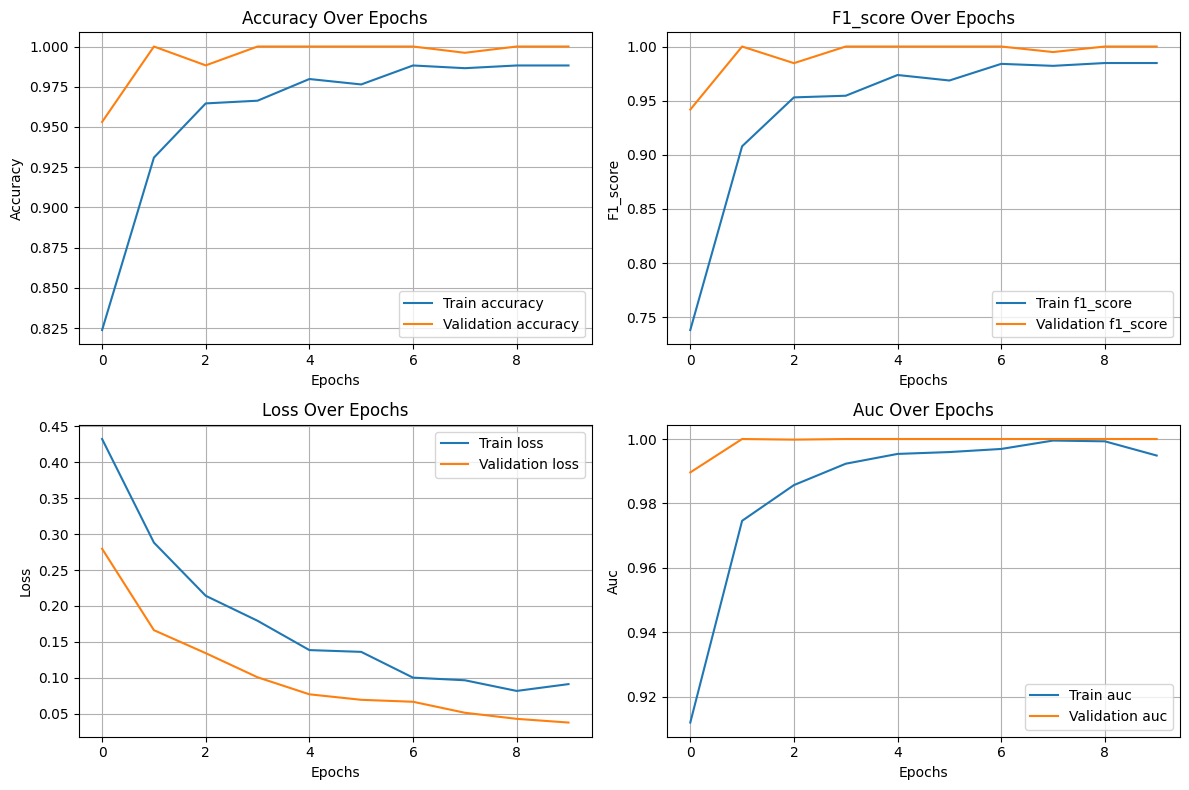

In [45]:
metrics = ["accuracy", "f1_score", "loss",'auc']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1) 
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()